In [5]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
style.use('ggplot')

In [6]:
SIZE = 10
EPISODES = 2500
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD =25
epsilon = 0.9
EPS_DECAY = 0.9998
SHOW_EVERY = 3000
LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

start_q_table = None
d={1:(255,175,0),2:(0,255,0),3:(0,0,255)}

In [7]:
class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x},{self.y}"

    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)

    def action(self, choice):
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
        
        if self.x<0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y<0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1
        

In [8]:
if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1,SIZE):
      for y1 in range(-SIZE+1,SIZE):
        for x2 in range(-SIZE+1,SIZE):
          for y2 in range(-SIZE+1,SIZE):
             q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
   with open(start_q_table,"rb") as f:
      q_table = pickle.load(f)

on #0,epsilon:0.9
3000 ep mean nan


/usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


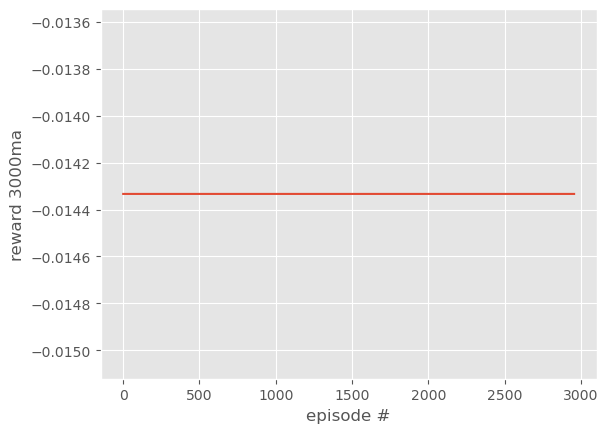

In [9]:
eps_rwds = []
for episode in range(EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()

    if episode%SHOW_EVERY == 0:
        print(f"on #{episode},epsilon:{epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(eps_rwds[-SHOW_EVERY:])}")
        show = False
    else:
        show = True
    
    eps_rwd  = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        if np.random.random()>epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,4)
    
    player.action(action)

    if player.x == enemy.x and player.y == enemy.y:
        reward = -ENEMY_PENALTY
    elif player.x == food.x and player.y == food.y:
        reward = FOOD_REWARD
    else:
        reward = -MOVE_PENALTY
    
    new_obs = (player-food,player-enemy)
    max_future_q = np.max(q_table[new_obs])
    current_q = q_table[obs][action]

    if reward == FOOD_REWARD:
        new_q = FOOD_REWARD
    elif reward == -ENEMY_PENALTY:
        new_q == -ENEMY_PENALTY
    else:
        new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE+(reward+DISCOUNT*max_future_q)
    
    q_table[obs][action] = new_q

    if show:
        env = np.zeros((SIZE,SIZE,3),dtype=np.uint8)
        env[food.y][food.x] = d[FOOD_N]
        env[player.y][player.x] = d[PLAYER_N]
        env[enemy.y][enemy.x] = d[ENEMY_N]

        img = Image.fromarray(env,'RGB')
        img = img.resize((600,600))
        cv2.imshow("",np.array(img))

        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            if cv2.waitKey(500) & 0xFF == ord('q'):
                break
        else:
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
        eps_rwd += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break
    
    eps_rwds.append(eps_rwd)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(eps_rwds, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.ylabel(f"reward {SHOW_EVERY}ma")
plt.xlabel(f"episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle","wb") as f:
    pickle.dump(q_table,f)